In [2]:
!pip install qiskit
!pip install qiskit-ionq

In [3]:
#import IonQ backends
from qiskit_ionq import IonQProvider
ionq_provider = IonQProvider(token='my token')

#Import other qiskit requirements
from qiskit import QuantumCircuit, Aer, execute
from qiskit.tools.visualization import plot_histogram, array_to_latex
from qiskit.extensions import UnitaryGate

### Question 1 : Implementing CNOT (Simulator vs. Hardware)

(i) Implement a simple quantum circuit with one CNOT gate and plot a histogram of the execution results
(ii) Repeat part (i), but use IonQ hardware, and observe the differences in the histogram
(iii) Now implement a quantum circuit with a CNOT gate that is activated when the control is in the state $\left| 0 \right>$ 

In [4]:
qc = QuantumCircuit(2, 2) #Instantiate a circuit with two qubits and two classical bits
qc.cx(0, 1)   # Apply the CNOT gate with control qubit 0 and target qubit 1

for i in range(len(qc.qubits)):  # Measure all the qubits
    qc.measure(i, i)
    
qc.draw() #Draw the circuit to visualize it 

┌─┐   
q_0: ──■──┤M├───
     ┌─┴─┐└╥┘┌─┐
q_1: ┤ X ├─╫─┤M├
     └───┘ ║ └╥┘
c: 2/══════╩══╩═
           0  1

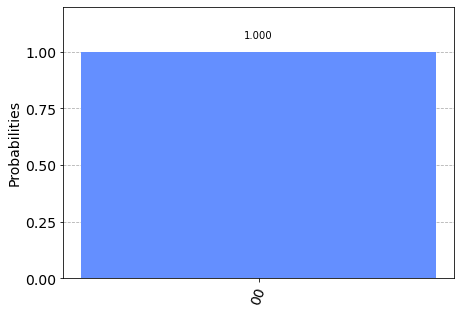

In [5]:
backend = Aer.get_backend('qasm_simulator') #choose your backend
job = execute(qc, backend) #create the job object
result = job.result() #create the result object
counts = result.get_counts()  #get the counts dictionary
plot_histogram(counts)  #plot the histogram of counts

This result makes sense : the control bit was in the state $\left| 0 \right>$, and therefore the target bit, which was in the state $\left| 0 \right>$ did not change. Now, let us run the circuit on IonQ hardware and see what happens

In [6]:
backend = ionq_provider.get_backend('ionq_qpu') #choose your backend
job = execute(qc, backend)  #get the job objecct

# check if job is complete
from qiskit.providers.jobstatus import JobStatus
import time
while job.status() is not JobStatus.DONE:
    print("Job status is", job.status() )
    time.sleep(60)
    
result = job.result() # get result object
counts = result.get_counts() #get the counts dictionary
plot_histogram(counts) #plot the histogram of the counts    

IonQAPIError: IonQAPIError(message='No error details provided.',status_code=401,error_type='Unauthorized')

So this time, we have some occurrences of the wrong results in the histogram. We should have ideally received all bit strings in the state $\left| 00 \right>$. But we have occurrences of other bit strings as well. This is because of errors in the quantum computer.

Finally, we need to make a CNOT gate that gets activated when the control bit is in the state $\left| 0 \right>$. How can we do this? Well, our traditional CNOT gate gets activated when the control qubit is in the state $\left| 1 \right>$. What if we add an $X$ gate before the CNOT gate in the path of the control qubit? What this will do is 

- change the $\left| 0 \right>$ state to the $\left| 1 \right>$ state, which will then activate the regular CNOT gate. So the state $\left| 0 \right>$ will effectively activate the CNOT gate.

- change the $\left| 1 \right>$ state to the $\left| 0 \right>$ state, which will then not activate the regular CNOT gate. So the $\left| 1 \right>$ state will not activate the CNOT gate anymore.

Finally, we will have to undo the effect of the $X$ gate that we will apply. So we will need to add an $X$ gate at the end.

Okay, let us try it!

In [12]:
# First we will create our very own, new quantum gate

my_circuit = QuantumCircuit(2) #Our gate is a two-qubit gate, so initialize a two-qubit quantum circuit
my_circuit.x(0)  #our gate has a NOT gate
my_circuit.cx(0, 1) #our gate then has a CNOT gate
my_circuit.x(0) #then we have a NOT gate
my_circuit.draw() #visualize

┌───┐     ┌───┐
q_0: ┤ X ├──■──┤ X ├
     └───┘┌─┴─┐└───┘
q_1: ─────┤ X ├─────
          └───┘

In [13]:
#convert your circuit to a gate
xcx = my_circuit.to_gate()
type(xcx)

qiskit.circuit.gate.Gate

In [14]:
qc = QuantumCircuit(2, 2) #Instantiate a circuit with two qubits and two classical bits
qc.append(xcx, [0, 1])   # Apply your special CNOT gate with control qubit 0 and target qubit 1
 
for i in range(len(qc.qubits)):  # Measure all the qubits
    qc.measure(i, i)
    
qc.draw() #Draw the circuit to visualize it 

┌─────────────┐┌─┐   
q_0: ┤0            ├┤M├───
     │  circuit-95 │└╥┘┌─┐
q_1: ┤1            ├─╫─┤M├
     └─────────────┘ ║ └╥┘
c: 2/════════════════╩══╩═
                     0  1

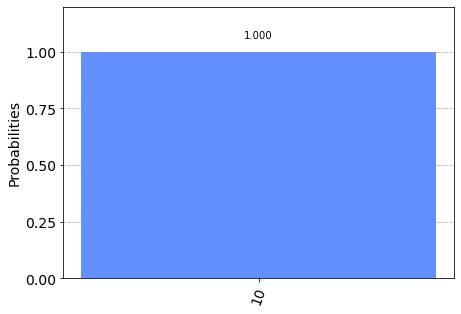

In [15]:
backend = Aer.get_backend('qasm_simulator') #choose your backend
job = execute(qc, backend) #create the job object
result = job.result() #create the result object
counts = result.get_counts()  #get the counts dictionary
plot_histogram(counts)  #plot the histogram of counts

This is the expected result. The bit string displayed in the histogram should be interpreted as the state $\left| 01 \right>$.

Now, let us move on to question 2.

### Question 2

Implement a Toffoli gate by creating a gate $V = \frac{1-i}{2}(I + iX)$, and then implementing the circuit from lecture.

In [17]:
#First we will create the V gate

matrix = [[0.5 * (1 - 1j), 0.5 * (1 - 1j) * 1j], #enter the matrix of the V-gate
        [0.5 * (1 - 1j) * 1j, 0.5 * (1 - 1j)]]

v = UnitaryGate(matrix, 'V') #Defining V

#Trying out our V-gate
qc = QuantumCircuit(1) #Initialise Quantum Circuit 
qc.unitary(v, 0) # Act unitary on circuit
print(qc.draw()) #Visualize circuit

#matrix of V-gate
backend = Aer.get_backend('unitary_simulator') #use unitary_simulator as backend
job = execute(qc, backend) #create job object
result = job.result() #create result object
matrix = result.get_unitary() #get the unitary matrix corresponding to the circuit
array_to_latex(matrix) #illustrate the matrix

     ┌─────────┐
q_0: ┤ unitary ├
     └─────────┘


<IPython.core.display.Latex object>

Okay, it's good that we defined the $V$ gate. But we actually need the controlled-$V$ gate

In [18]:
controlled_v = v.control() #define the controlled-v operation

# Trying out the controlled-v gate
qc = QuantumCircuit(2)  # Define a quantum circuit
qc.append(controlled_v, [0, 1]) #Append the controlled_v gate
qc.draw() #Visualize

q_0: ──■──
     ┌─┴─┐
q_1: ┤ V ├
     └───┘

Finally, we are also going to need the controlled-$V^{\dagger}$

In [19]:
v_dagger = v.adjoint() #define v-dagger
controlled_v_dagger = v_dagger.control() #define the controlled-v-dagger

#Trying it out
qc = QuantumCircuit(1) #Define a quantum circuit
qc.unitary(v_dagger, 0) #implement v-dagger
print(qc.draw()) #Visualize

#matrix of V-dagger
backend = Aer.get_backend('unitary_simulator') #use unitary_simulator as backend
job = execute(qc, backend) #create job object
result = job.result() #create result object
matrix = result.get_unitary() #get the unitary matrix corresponding to the circuit
array_to_latex(matrix) #illustrate the matrix

     ┌─────────┐
q_0: ┤ unitary ├
     └─────────┘


<IPython.core.display.Latex object>

Okay, now let us create our Toffoli gate circuit!

In [20]:
qc = QuantumCircuit(3)  #A Toffoli gate is a 3-qubit gate. So define a 3-qubit quantum circuit
qc.append(controlled_v, [1, 2])  #Append your controlled-V operation.
qc.cx(0, 1)  #CNOT
qc.append(controlled_v_dagger, [1, 2]) #Controlled-V dagger
qc.cx(0, 1)  #CNOT
qc.append(controlled_v, [0, 2]) #One more controlled-V
print(qc.draw()) #Visualize

# Let us check to see if we got the right transformation. Let's get the matrix

backend = Aer.get_backend('unitary_simulator') #use unitary_simulator as backend
job = execute(qc, backend) #create job object
result = job.result() #create result object
matrix = result.get_unitary() #get the unitary matrix corresponding to the circuit
array_to_latex(matrix) #illustrate the matrix

                                    
q_0: ───────■───────────────■────■──
          ┌─┴─┐           ┌─┴─┐  │  
q_1: ──■──┤ X ├─────■─────┤ X ├──┼──
     ┌─┴─┐└───┘┌────┴────┐└───┘┌─┴─┐
q_2: ┤ V ├─────┤ unitary ├─────┤ V ├
     └───┘     └─────────┘     └───┘


<IPython.core.display.Latex object>

In [21]:
#Let's compare with the matrix of the Toffoli gate

qc = QuantumCircuit(3) #Create 3-qubit quantum circuit
qc.toffoli(0, 1, 2) # Apply Toffoli gate
print(qc.draw()) #Visualize

backend = Aer.get_backend('unitary_simulator') #use unitary_simulator as backend
job = execute(qc, backend) #create job object
result = job.result() #create result object
matrix = result.get_unitary() #get the unitary matrix corresponding to the circuit
array_to_latex(matrix) #illustrate the matrix

          
q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘


<IPython.core.display.Latex object>

We have the same matrix - it worked!